In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

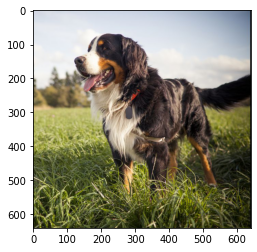

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image("images/large_dog.jpg")

plt.imshow(img)

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [4]:
model = models.inception_v3(pretrained=True)

In [5]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [6]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [7]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.91473156, 239, 'Bernese_mountain_dog'),
 (0.051834784, 240, 'Appenzeller'),
 (0.020381039, 241, 'EntleBucher'),
 (0.013044636, 238, 'Greater_Swiss_Mountain_dog'),
 (1.7456049e-06, 214, 'Gordon_setter'))

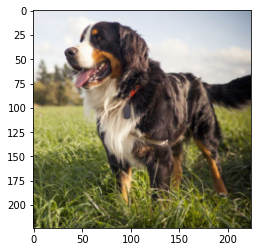

In [8]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

plt.imshow(np.array(pill_transf(img)))

In [9]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [10]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

239

In [11]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

segmenter = SegmentationAlgorithm('slic', n_segments=50, compactness=80)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=400,
                                         segmentation_fn= segmenter)


In [12]:
def get_torch_mask(mask):
    mask_ = 1 - mask
    torch_mask = torch.from_numpy(mask_)
    torch_mask = torch_mask.unsqueeze(0)
    torch_mask = torch_mask.unsqueeze(0)
    torch_mask = torch_mask.repeat(1, 3, 1, 1)
    return torch_mask.float()

In [29]:
from advertorch.attacks import FGSM 
from advertorch.utils import  _get_norm_batch as get_norm
import time
from advertorch.context import ctx_noparamgrad_and_eval

def compute_c_Eval_GSA(data, mask, model, start_ep = 0.01, step_size = 0.01, max_iter = 100):
    start = time.time()
    model.eval()
    output = model(data)
    pred_label = output.max(1, keepdim=True)[1][:,0]
    old_label = output.argmax().item()
    delta = torch.zeros_like(data)
    prev_data = data.clone()
    
    ep = start_ep
    for i in range(max_iter):
        adversary = FGSM(model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=ep, clip_min=data.min().item(), 
                                              clip_max=data.max().item(), targeted=False)
        with ctx_noparamgrad_and_eval(model):
            adv_data = adversary.perturb(prev_data, pred_label)
        
        delta = adv_data - prev_data
        delta = delta * mask
        adv_data = prev_data + delta
        new_label = model(adv_data).argmax().item()
        if new_label != old_label:
            break
        prev_data = data.clone()
        ep = ep + step_size
        
    if (new_label != old_label):
        print("Success at iteration: ", i)
    else:
        print("Fail")
    print("Duration: ", time.time() - start)
    
    return adv_data, ep - step_size

In [34]:
upper_no_seg = 30
step_size_ = 0.00001
start_ep_ = 0.0002
max_iter_ = 1000

mask_limes = []
for i in range(0,upper_no_seg):
    temp, mask_lime = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=i, hide_rest=True)
    mask_limes.append(mask_lime)
    
c_limes = []
this_ep = start_ep_
count = 0
for mask_lime in mask_limes:
    torch_mask_lime = get_torch_mask(mask_lime)
    adv_lime, next_ep = compute_c_Eval_GSA(img_t,torch_mask_lime, model, 
                          start_ep = this_ep,
                          step_size = step_size_, max_iter = max_iter_)
    diff_lime = img_t - adv_lime
    c_lime = get_norm(diff_lime, 2).item()
    c_limes.append(c_lime)
    this_ep = next_ep
    print("Number of segment: ", count)
    count =count + 1
    print("c-Eval:", c_lime)
    print("\n")

Success at iteration:  256
Duration:  71.70600914955139
Number of segment:  0
c-Eval: 1.0564696788787842


Success at iteration:  18
Duration:  4.99877405166626
Number of segment:  1
c-Eval: 1.1095551252365112


Success at iteration:  16
Duration:  4.879592418670654
Number of segment:  2
c-Eval: 1.1554449796676636


Success at iteration:  15
Duration:  4.628356456756592
Number of segment:  3
c-Eval: 1.1925055980682373


Success at iteration:  15
Duration:  4.706226110458374
Number of segment:  4
c-Eval: 1.2309935092926025


Success at iteration:  18
Duration:  5.450332403182983
Number of segment:  5
c-Eval: 1.2787898778915405


Success at iteration:  5
Duration:  1.57863187789917
Number of segment:  6
c-Eval: 1.2773696184158325


Success at iteration:  12
Duration:  3.2317404747009277
Number of segment:  7
c-Eval: 1.300553798675537


Success at iteration:  22
Duration:  6.680898666381836
Number of segment:  8
c-Eval: 1.3583850860595703


Success at iteration:  14
Duration:  4.035275220

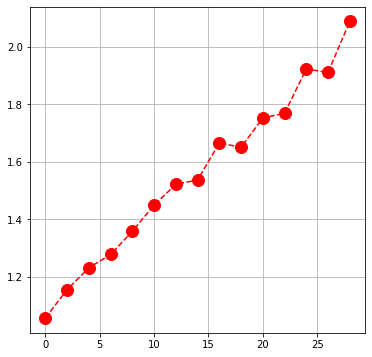

In [35]:
upper_plot = 30

t =[i for i in range(0,upper_plot) if i%2 == 0]
c_Eval = [c_limes[i] for i in t]

fig, ax = plt.subplots(figsize=(6,6))


# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(22)

# ax.set_xlabel('Number of segments (k)', fontsize=26)
# ax.set_ylabel('c-Eval', fontsize=26)

ax.plot(t, c_Eval, linestyle='--', marker='o', color='r', markersize=12, label = 'GS') 
# ax.plot(t, c_1000, linestyle='--', marker='s', color='b', markersize=12, label = '1000 samples') 
# ax.plot(t, c_4000, linestyle='--', marker='*', color='g', markersize=12, label = '4000 samples')
# ax.plot(t, c_10000, linestyle='--', marker='d', color='m', markersize=12, label = '10000 samples') 
ax.grid()
# ax.legend(loc="upper left", markerscale=1.2, scatterpoints=1, fontsize=24)

# plt.savefig('results/c_GS.png', bbox_inches='tight')


plt.show()

In [36]:
with open("results/c_Eval_GS_1.csv", "ab") as f:
            np.savetxt(f, c_limes)